In [1]:
import numpy as np
import pandas as pd
import os 
import time
import deepdish.io as dd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F

from svi import SVI
import models as m
import datasets as d

from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
df = pd.read_csv("whole_table.csv")

In [5]:
df.columns

Index(['Unnamed: 0', 'H_alpha', '1.d SGF', '2.d SGF', 'MM 4', 'MM 6', 'MM 8',
       'MM 10', 'MM 12', 'MM 14', 'MM 16', 'EMM 4', 'EMM 6', 'EMM 8', 'EMM 10',
       'EMM 12', 'EMM 14', 'EMM 16', 'MV 5', 'MV 6', 'MV 7', 'MV 8', 'MV 9',
       'MV 10', 'MV 11', 'MV 12', 'MV 13', 'MV 14', 'MV 15', 'MV 16',
       'Spectral_centroid', 'Spectral_rolloff', 'mfcc_0', 'mfcc_1', 'mfcc_2',
       'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9',
       'BR_current', 'BV_current', 'MFPS_current', 'raw_density', 'q95',
       'EFIT_plasma_volume', 'EFIT_minor_radius', 'EFIT_magentic_axis_z',
       'EFIT_plasma_energy', 'labels'],
      dtype='object')

In [59]:
df1 = df.drop(["Unnamed: 0", "MM 4", "MM 6", "MM 8", "MM 10", "MM 12", "MM 14", 
         "EMM 4", "EMM 6","EMM 8","EMM 10","EMM 12","EMM 14", "EMM 16",
         "MV 5", "MV 6", "MV 7", "MV 8", "MV 9", "MV 10", "MV 11", "MV 12", "MV 13", "MV 14", "MV 15",
         "Spectral_rolloff", "mfcc_0", "mfcc_1", "mfcc_2", "mfcc_4", "mfcc_5", "mfcc_6", "mfcc_7", "mfcc_8", "mfcc_9",
         "EFIT_plasma_volume"], axis=1)

In [60]:
df1 = df1.dropna()

In [61]:
labels = df1.labels.values

In [62]:
df1 = df1.drop(["labels"], axis=1)
df1.head()

,H_alpha,1.d SGF,2.d SGF,MM 16,MV 16,Spectral_centroid,mfcc_3,BR_current,BV_current,MFPS_current,raw_density,q95,EFIT_minor_radius,EFIT_magentic_axis_z,EFIT_plasma_energy
0,0.965271,0.008733,-0.002338,0.965271,0.000000,0.234894,0.546271,107.755452,355.531367,3741.359090,4.293898,4.067153,0.194522,0.004209,720.812208
1,1.020789,0.008706,-0.003834,0.993030,0.000771,0.243809,0.539870,50.798999,360.900432,3736.420298,3.907752,4.066039,0.194496,0.004210,725.633097
2,1.084411,0.006173,-0.006263,1.023490,0.002369,0.254557,0.527436,76.968180,305.089226,3727.665168,4.254782,4.064924,0.194470,0.004210,730.453986
3,1.022004,0.005018,-0.004623,1.023119,0.001777,0.260214,0.518505,121.655000,302.156544,3714.869208,4.663996,4.063810,0.194444,0.004211,735.274876
4,0.980265,0.001033,-0.003157,1.014548,0.001716,0.259237,0.516993,65.558779,248.104947,3701.399776,3.778368,4.062696,0.194418,0.004211,740.095765


In [63]:
df1.shape

(75718, 15)

In [64]:
df1.shape

(75718, 15)

In [65]:
X = df1.values
y = labels

In [66]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=0.2, random_state=666)

In [67]:
X_train

array([[ 1.59437989e+00, -3.28323438e-02,  2.40154189e-03, ...,
         1.93529626e-01,  1.66920067e-02,  3.93722680e+03],
       [ 5.39123483e-01, -3.44838396e-03,  6.21889788e-04, ...,
         1.79330528e-01,  1.59033957e-02,  3.20667779e+02],
       [ 1.07003813e+00, -1.27455571e-02,  4.49435729e-03, ...,
         1.87500134e-01,  1.09341110e-02,  2.69231497e+03],
       ...,
       [ 7.66705839e-01,  1.22340641e-01, -2.19528955e-02, ...,
         1.68519893e-01,  1.96233772e-02,  3.97320367e+03],
       [ 1.00504776e+00, -3.93645790e-03, -6.73153363e-04, ...,
         1.95204258e-01,  4.68114494e-03,  1.15551896e+03],
       [ 4.12554617e-01,  2.31965567e-03, -8.42124306e-04, ...,
         1.68075406e-01,  1.75355514e-02,  4.89929311e+03]])

In [68]:
X_test

array([[ 6.63684089e-01, -2.11366934e-03, -3.11730930e-02, ...,
         1.79282892e-01,  2.03524119e-02,  3.48983276e+03],
       [ 1.19200978e+00,  1.52228564e-02,  2.79144011e-03, ...,
         1.93353006e-01,  1.71649850e-02,  3.19531709e+03],
       [ 4.11740726e-01,  6.72645740e-04,  2.28538957e-04, ...,
         1.84229571e-01,  2.74654819e-02,  4.31124558e+03],
       ...,
       [ 4.47325362e-01,  2.32850850e-03, -4.41890813e-04, ...,
         1.77036270e-01,  2.94693925e-02,  4.63793205e+03],
       [ 9.71156294e-01,  1.99161807e-02,  2.51198665e-03, ...,
         1.90158933e-01,  1.84193307e-02,  4.77504907e+03],
       [ 1.94023101e+00, -2.13571269e-02, -1.53381626e-02, ...,
         1.88321810e-01,  1.07726986e-02,  3.30646163e+03]])

In [69]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [70]:
X_train

array([[ 1.49139484, -2.27952255,  0.20292891, ...,  0.93974662,
        -0.17203461,  0.20242467],
       [-0.33897659, -0.16989568,  0.01091287, ...,  0.21383694,
        -0.27778941, -1.8826177 ],
       [ 0.58190955, -0.83738796,  0.4287338 , ...,  0.63149703,
        -0.94418356, -0.51530008],
       ...,
       [ 0.05577131,  8.8611508 , -2.42479971, ..., -0.33884214,
         0.22106988,  0.22316629],
       [ 0.46918195, -0.20493704, -0.12881616, ...,  1.02535992,
        -1.78272275, -1.40130382],
       [-0.55851379,  0.2442218 , -0.14704733, ..., -0.36156592,
        -0.05891305,  0.75708147]])

In [71]:
X_embedded = TSNE(n_components=3, verbose=True).fit_transform(X_test)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15144 samples in 0.017s...
[t-SNE] Computed neighbors for 15144 samples in 3.873s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15144
[t-SNE] Computed conditional probabilities for sample 2000 / 15144
[t-SNE] Computed conditional probabilities for sample 3000 / 15144
[t-SNE] Computed conditional probabilities for sample 4000 / 15144
[t-SNE] Computed conditional probabilities for sample 5000 / 15144
[t-SNE] Computed conditional probabilities for sample 6000 / 15144
[t-SNE] Computed conditional probabilities for sample 7000 / 15144
[t-SNE] Computed conditional probabilities for sample 8000 / 15144
[t-SNE] Computed conditional probabilities for sample 9000 / 15144
[t-SNE] Computed conditional probabilities for sample 10000 / 15144
[t-SNE] Computed conditional probabilities for sample 11000 / 15144
[t-SNE] Computed conditional probabilities for sample 12000 / 15144
[t-SNE] Computed conditional probabilities for sam

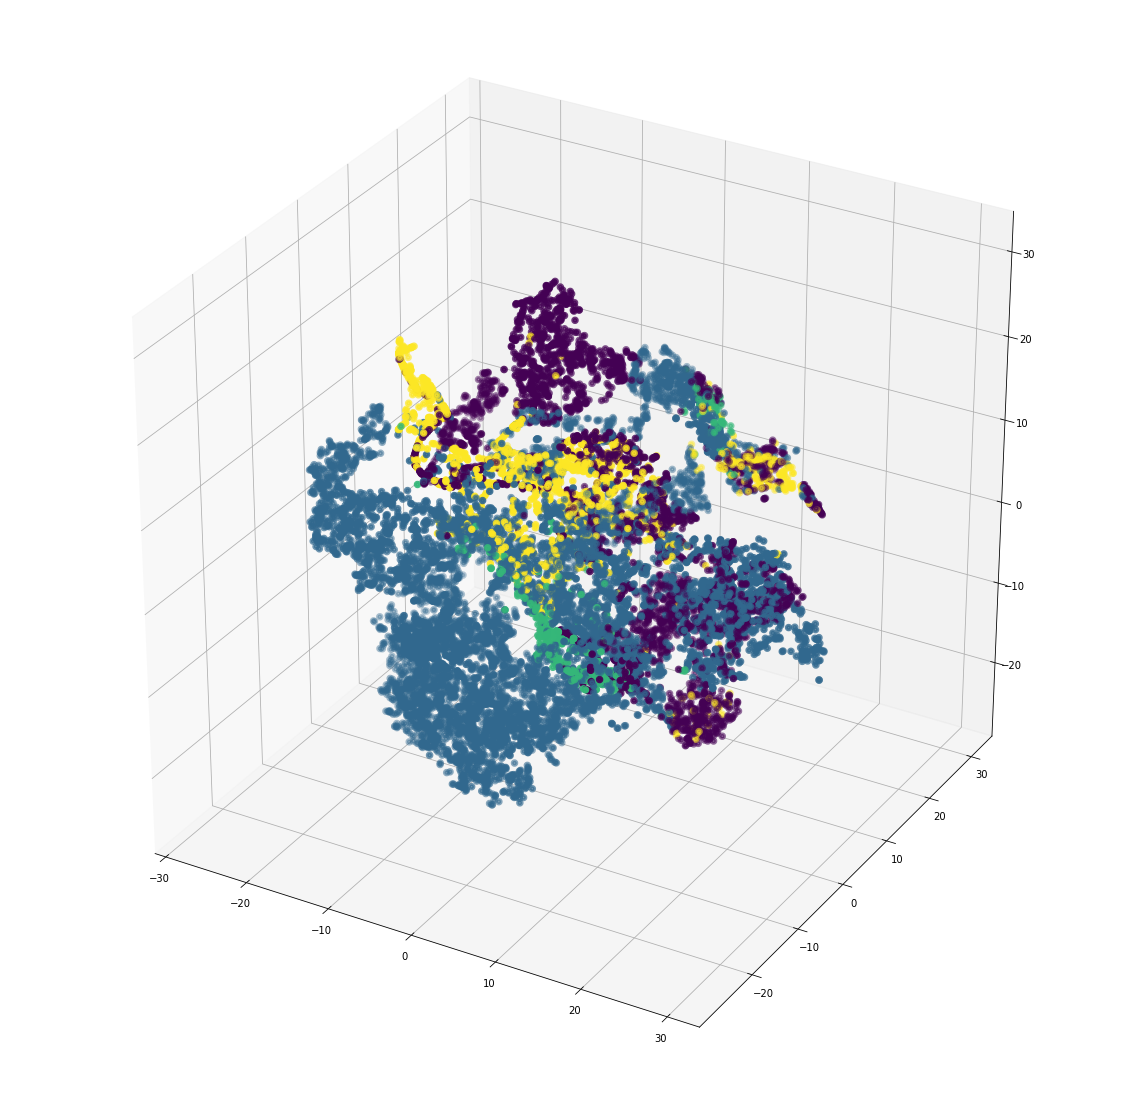

In [73]:
# t-SNE
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_embedded[:,0], X_embedded[:,1], X_embedded[:,2], c=y_test, lw=3)

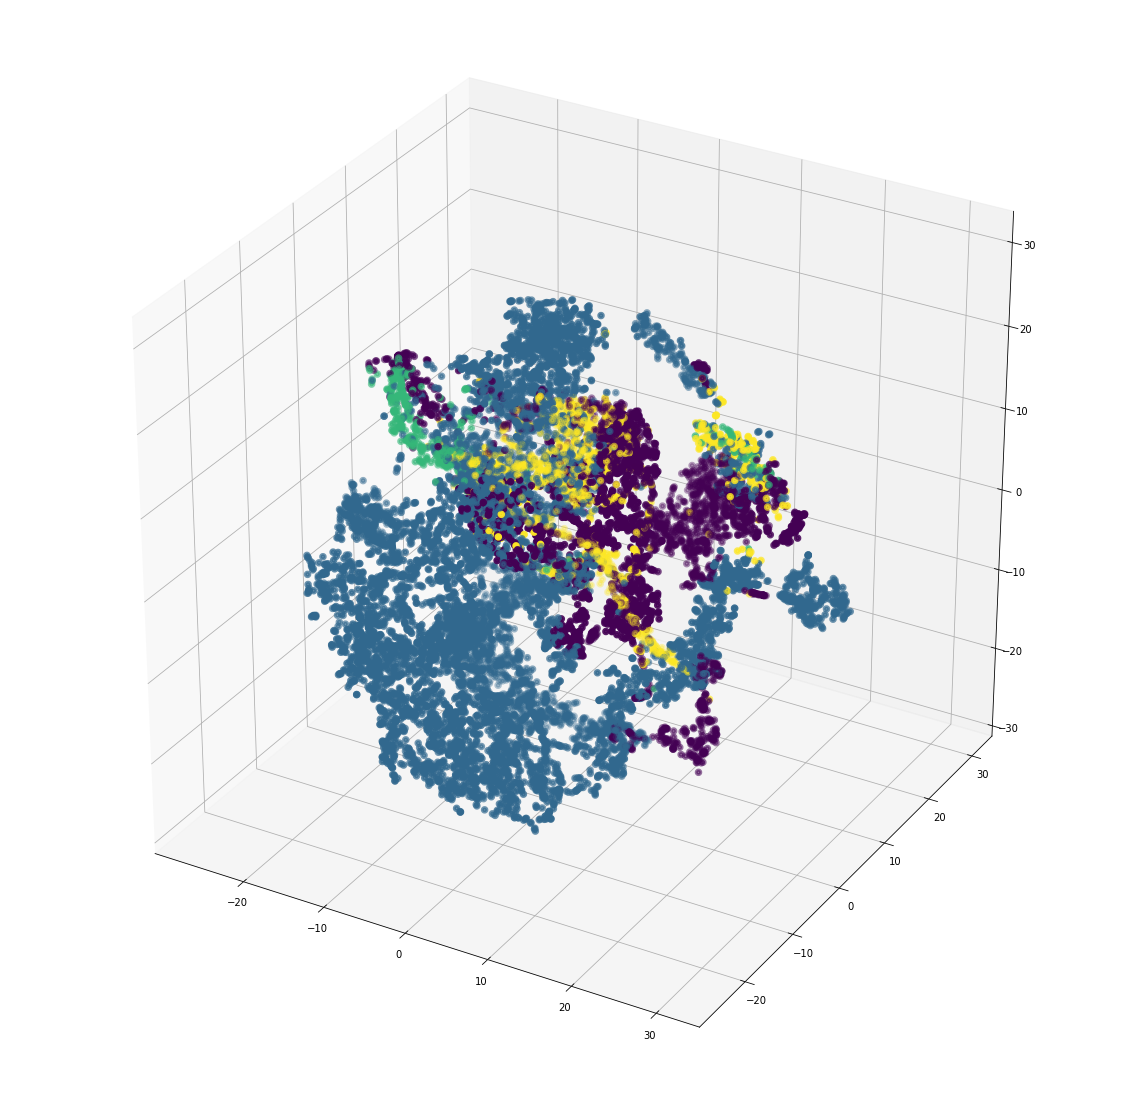

In [77]:
# t-SNE
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_embedded[:,1], X_embedded[:,2], X_embedded[:,0], c=y_test, lw=3)

In [94]:
#np.save("VAE-saved_model_and_losses/t-SNE-emebeded_test_original_tree_based.npy", X_embedded)

# Jen H_alpha

In [82]:
df2 = df.drop(["Unnamed: 0",
         "Spectral_centroid", "mfcc_3", "BR_current", "BV_current", "MFPS_current", "raw_density",
         "Spectral_rolloff", "mfcc_0", "mfcc_1", "mfcc_2", "mfcc_4", "mfcc_5", "mfcc_6", "mfcc_7", "mfcc_8", "mfcc_9",
         "EFIT_plasma_volume", "q95", "EFIT_minor_radius", "EFIT_magentic_axis_z", "EFIT_plasma_energy"], axis=1)

In [83]:
df2 = df2.dropna()

In [84]:
df2

,H_alpha,1.d SGF,2.d SGF,MM 4,MM 6,MM 8,MM 10,MM 12,MM 14,MM 16,...,MV 8,MV 9,MV 10,MV 11,MV 12,MV 13,MV 14,MV 15,MV 16,labels
0,0.965271,0.008733,-0.002338,0.965271,0.965271,0.965271,0.965271,0.965271,0.965271,0.965271,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
1,1.020789,0.008706,-0.003834,0.993030,0.993030,0.993030,0.993030,0.993030,0.993030,0.993030,...,0.000771,0.000771,0.000771,0.000771,0.000771,0.000771,0.000771,0.000771,0.000771,1.0
2,1.084411,0.006173,-0.006263,1.023490,1.023490,1.023490,1.023490,1.023490,1.023490,1.023490,...,0.002369,0.002369,0.002369,0.002369,0.002369,0.002369,0.002369,0.002369,0.002369,1.0
3,1.022004,0.005018,-0.004623,1.023119,1.023119,1.023119,1.023119,1.023119,1.023119,1.023119,...,0.001777,0.001777,0.001777,0.001777,0.001777,0.001777,0.001777,0.001777,0.001777,1.0
4,0.980265,0.001033,-0.003157,1.026867,1.014548,1.014548,1.014548,1.014548,1.014548,1.014548,...,0.001716,0.001716,0.001716,0.001716,0.001716,0.001716,0.001716,0.001716,0.001716,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92273,0.703094,-0.001280,0.003304,0.737648,0.742407,0.749652,0.750036,0.757858,0.755013,0.748552,...,0.002659,0.002460,0.002348,0.002135,0.002659,0.002489,0.002579,0.002625,0.002556,1.0
92274,0.728966,0.004432,0.004094,0.741144,0.740057,0.742062,0.744454,0.748127,0.757369,0.749688,...,0.002454,0.002405,0.002241,0.002171,0.001990,0.002514,0.002373,0.002450,0.002490,1.0
92275,0.662770,0.005940,0.006036,0.737328,0.723721,0.730772,0.738895,0.741008,0.749003,0.747620,...,0.003097,0.002802,0.002809,0.002588,0.002547,0.002355,0.002906,0.002772,0.002776,1.0
92276,0.710319,0.003217,0.011651,0.701287,0.722944,0.726679,0.730959,0.734803,0.739330,0.748516,...,0.003114,0.002795,0.002570,0.002621,0.002427,0.002418,0.002251,0.002806,0.002696,1.0


In [85]:
labels2 = df2.labels.values

In [86]:
df2 = df2.drop(["labels"], axis=1)
df2.head()

,H_alpha,1.d SGF,2.d SGF,MM 4,MM 6,MM 8,MM 10,MM 12,MM 14,MM 16,...,MV 7,MV 8,MV 9,MV 10,MV 11,MV 12,MV 13,MV 14,MV 15,MV 16
0,0.965271,0.008733,-0.002338,0.965271,0.965271,0.965271,0.965271,0.965271,0.965271,0.965271,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.020789,0.008706,-0.003834,0.993030,0.993030,0.993030,0.993030,0.993030,0.993030,0.993030,...,0.000771,0.000771,0.000771,0.000771,0.000771,0.000771,0.000771,0.000771,0.000771,0.000771
2,1.084411,0.006173,-0.006263,1.023490,1.023490,1.023490,1.023490,1.023490,1.023490,1.023490,...,0.002369,0.002369,0.002369,0.002369,0.002369,0.002369,0.002369,0.002369,0.002369,0.002369
3,1.022004,0.005018,-0.004623,1.023119,1.023119,1.023119,1.023119,1.023119,1.023119,1.023119,...,0.001777,0.001777,0.001777,0.001777,0.001777,0.001777,0.001777,0.001777,0.001777,0.001777
4,0.980265,0.001033,-0.003157,1.026867,1.014548,1.014548,1.014548,1.014548,1.014548,1.014548,...,0.001716,0.001716,0.001716,0.001716,0.001716,0.001716,0.001716,0.001716,0.001716,0.001716


In [89]:
X = df2.values
y = labels2

In [90]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(np.array(X), np.array(y), test_size=0.2, random_state=666)

In [91]:
X_embedded2 = TSNE(n_components=3, verbose=True).fit_transform(X_test1)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 16800 samples in 0.037s...
[t-SNE] Computed neighbors for 16800 samples in 5.237s...
[t-SNE] Computed conditional probabilities for sample 1000 / 16800
[t-SNE] Computed conditional probabilities for sample 2000 / 16800
[t-SNE] Computed conditional probabilities for sample 3000 / 16800
[t-SNE] Computed conditional probabilities for sample 4000 / 16800
[t-SNE] Computed conditional probabilities for sample 5000 / 16800
[t-SNE] Computed conditional probabilities for sample 6000 / 16800
[t-SNE] Computed conditional probabilities for sample 7000 / 16800
[t-SNE] Computed conditional probabilities for sample 8000 / 16800
[t-SNE] Computed conditional probabilities for sample 9000 / 16800
[t-SNE] Computed conditional probabilities for sample 10000 / 16800
[t-SNE] Computed conditional probabilities for sample 11000 / 16800
[t-SNE] Computed conditional probabilities for sample 12000 / 16800
[t-SNE] Computed conditional probabilities for sam

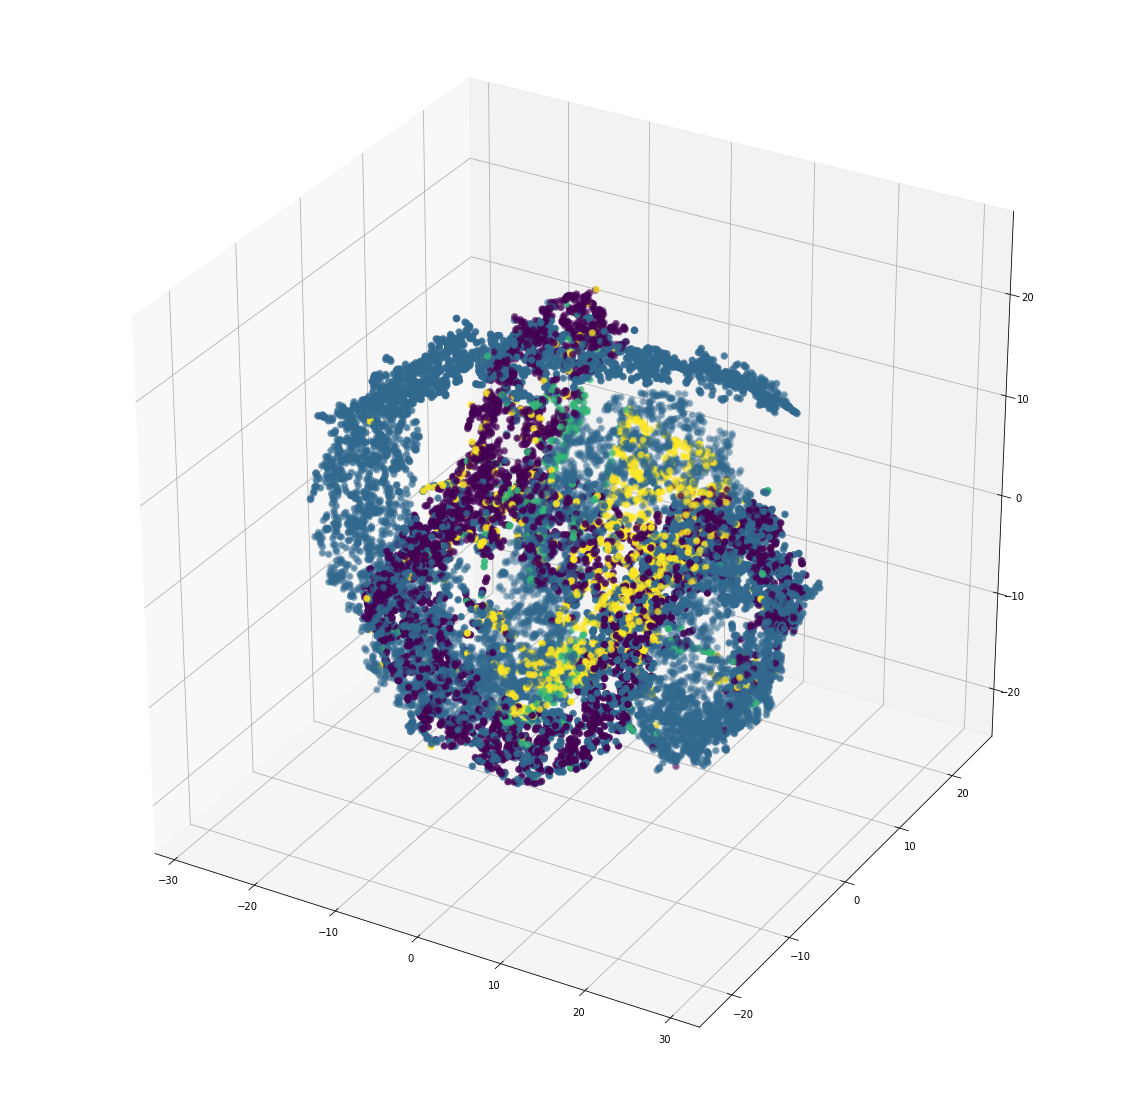

In [93]:
# t-SNE
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_embedded2[:,0], X_embedded2[:,1], X_embedded2[:,2], c=y_test1, lw=3)

In [95]:
#np.save("VAE-saved_model_and_losses/t-SNE-emebeded_test_original_all_from_h_alpha.npy", X_embedded2)